In [7]:
#importing necessary libraries 
import requests
import pandas as pd
import matplotlib
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
from io import BytesIO
from PIL import Image
import csv 
from bs4 import BeautifulSoup as bs
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from webdriver_manager.chrome import ChromeDriverManager

In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aleksanderkaspersen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
books_recommend = pd.read_csv('Data_processing3.csv', sep =',')

In [10]:
books_recommend.head()

,Unnamed: 0,ISBN,Title,Author,Year,Publisher,Blurb,imageUrlL,averageRating,ratingCount,wordCount,cleanedBlurb
0,1,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,"The fascinating, true story of the world's dea...",http://images.amazon.com/images/P/0374157065.0...,4.272727,11,180,fascinating true story world's deadliest disea...
1,2,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,Winnie and Helen have kept each others worst s...,http://images.amazon.com/images/P/0399135782.0...,4.212121,33,94,winnie helen kept others worst secrets fifty y...
2,3,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group,Historians and inquisitive laymen alike love t...,http://images.amazon.com/images/P/0425176428.0...,1.600000,5,63,historians inquisitive laymen alike love ponde...
3,4,1881320189,Goodbye to the Buttermilk Sky,Julia Oliver,1994,River City Pub,This highly praised first novel by fiction wri...,http://images.amazon.com/images/P/1881320189.0...,4.666667,3,268,highly praised first novel fiction writer juli...
4,5,0440234743,The Testament,John Grisham,1999,Dell,"In a plush Virginia office, a rich, angry old ...",http://images.amazon.com/images/P/0440234743.0...,3.085308,422,152,plush virginia office rich angry old man furio...


In [11]:
books_recommend.shape

(44306, 12)

In [12]:
#Making a webdriver for the web scraping
op = webdriver.ChromeOptions()
op.add_argument('headless')
driver = webdriver.Chrome(ChromeDriverManager().install(), options=op)



====== WebDriver manager ======
Current google-chrome version is 98.0.4758
Get LATEST chromedriver version for 98.0.4758 google-chrome
Driver [/Users/aleksanderkaspersen/.wdm/drivers/chromedriver/mac64/98.0.4758.80/chromedriver] found in cache
<ipython-input-12-16de571c025b>:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install(), options=op)


In [13]:
#making a function that inserts the ISBN number we want to the amazon url
def get_url(search_term):
    template = 'https://www.amazon.com/s?k={}&ref=nb_sb_noss_1'
    search_term = search_term.replace(' ','+')
    return template.format(search_term)

In [15]:
#making the blurbs into vectors using TD-IDF, i use bigrams since i din't have enough RAM to run unigrams
tf = TfidfVectorizer(ngram_range=(2, 2), stop_words='english', lowercase = False)
tfidf_matrix = tf.fit_transform(books_recommend['cleanedBlurb'])
tfidf_matrix.shape

(44306, 2103100)

In [16]:
#calculating the cosine similarity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim.shape

(44306, 44306)

In [17]:
indices = pd.Series(books_recommend.index, index=books_recommend['Title'])
indices.head()

Title
Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It    0
The Kitchen God's Wife                                                                                1
What If?: The World's Foremost Military Historians Imagine What Might Have Been                       2
Goodbye to the Buttermilk Sky                                                                         3
The Testament                                                                                         4
dtype: int64

In [18]:
# the function for the recommendation 
def recommend(title):
    try:
        idx = indices[title]
        #making a list of the simularity score and sorting them from most simular to least  
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        #taking the five most similar items
        sim_scores = sim_scores[1:6] 
        book_indices = [i[0] for i in sim_scores]
        
        recommendations = books_recommend[['Title', 'imageUrlL', 'Author', 'Blurb', 'ISBN']].iloc[book_indices] #recommended books
        df = recommendations[['Title', 'Author']]
        print(df.to_string(index=False))
            
        #iterate through the ISBN codes of the recommended books and uses the get_url function to get the amazon url
        url = []
        for i in recommendations['ISBN']:
            url.append(get_url(i))
        
        #using webscraping from the url's to get thre prices of the books    
        prices = []
        for i in url:
            #sometimes the price isn't displayed so i use try and expect in case i don't find the price 
            try:
                driver.get(i)
                soup = bs(driver.page_source, 'html.parser')
                results = soup.find_all('div', {'class':'a-section a-spacing-base'})
                item = results[0]
                price_parent = item.find('span', 'a-price')
                prices.append(price_parent.find('span', 'a-offscreen').text)
            except:
                prices.append('no price')
        
        
        
      #display the book-covers 
        images = []
        for i in recommendations['imageUrlL']:
            response = requests.get(i)
            img = Image.open(BytesIO(response.content))
            images.append(img)
            
        
        fig = plt.figure()
        fig.set_figheight(15)
        fig.set_figwidth(15)
        fig.add_subplot(1, 5, 1)
        imgplot = plt.imshow(images[0])
        plt.axis('off')
        plt.title('Price '+ prices[0])
        fig.add_subplot(1, 5, 2)
        imgplot = plt.imshow(images[1])
        plt.axis('off')
        plt.title('Price '+ prices[1])
        fig.add_subplot(1, 5, 3)
        imgplot = plt.imshow(images[2])
        plt.axis('off')
        plt.title('Price '+ prices[2])
        fig.add_subplot(1, 5, 4)
        imgplot = plt.imshow(images[3])
        plt.axis('off')
        plt.title('Price '+ prices[3])
        fig.add_subplot(1, 5, 5)
        imgplot = plt.imshow(images[4])
        plt.axis('off')
        plt.title('Price '+ prices[4])
        plt.show()
    #if i don't find the book, the program will list every book containing the word searched for    
    except KeyError:
        print('Seems like this book is not in the database. Try another one! \n',
            'Here are som books with the words', title, 'in it:')

        for i in books_recommend['Title']:
            if title in i:
                print(i)
            else:
                None

                                                                                              Title           Author
                                                                             The Seduction of Water    CAROL GOODMAN
                                         Ultimate Unofficial Guide to the Mysteries of Harry Potter Galadriel Waters
                                                      J. K. Rowling: The Wizard Behind Harry Potter     Marc Shapiro
The Gospel According to Harry Potter: Spirituality in the Stories of the World's Most Famous Seeker      Connie Neal
                                                                Harry Potter a l'ecole des sorciers    J. K. Rowling


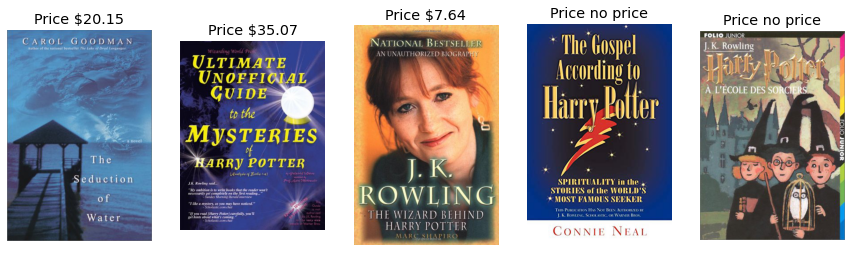

In [272]:
recommend("Harry Potter Et LA Coupe De Feu")

In [20]:
recommend("Python")

Seems like this book is not in the database. Try another one! 
 Here are som books with the words Python in it:
The Complete Monty Python's Flying Circus : All the Words, Volume 2
The Complete Monty Python's Flying Circus : All the Words, Volume 1
Monty Python Speaks


                               Title        Author
              Beloved : Gift Edition TONI MORRISON
                             Beloved Toni Morrison
                             Beloved TONI MORRISON
        O'Hara's Choice (Uris, Leon)     Leon Uris
Mr. Blandings Builds His Dream House  Eric Hodgins


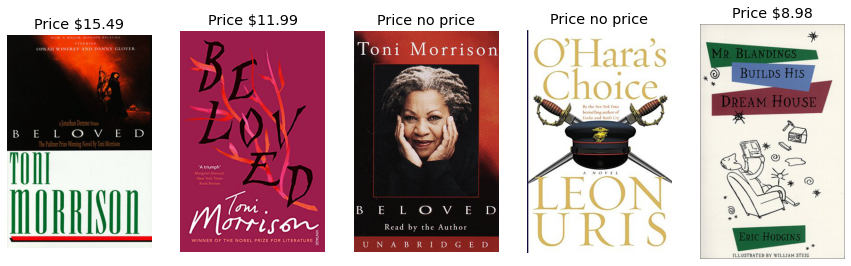

In [19]:
recommend("Beloved (Plume Contemporary Fiction)")